In [1]:
pip install python_speech_features


  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=6158e583bdb6bcab928f4bc0cde2c15a012e420db0f231c82b93be875ed2d982
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python_speech_features
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from python_speech_features import mfcc, logfbank
import librosa
from scipy.io import wavfile

In [4]:
from tqdm import tqdm
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt


In [5]:
from keras.layers import Conv2D, MaxPool2D, Flatten,LSTM 
from keras.layers import Dropout , Dense , TimeDistributed
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

In [6]:
from sklearn.model_selection import train_test_split 


In [7]:
#importer data 
data=pd.read_csv("/kaggle/input/freesound-audio-tagging/train.csv")
#instruments=np.array(["Violin_or_fiddle" ,"Acoustic_guitar","Electric_piano","Cowbell","Tambourine","Double_bass","Gong","Harmonica","Bass_drum","Chime","Flute","Oboe","Snare_drum","Clarinet","Cello","Glockenspiel","Trumpet","Saxophone","Hi-hat"])
instruments=np.array(['Violin_or_fiddle', 'Acoustic_guitar', 'Double_bass', 'Bass_drum',
       'Flute', 'Snare_drum', 'Clarinet', 'Cello', 'Saxophone', 'Hi-hat'])
instruments.shape

(10,)

In [8]:
df=data.copy()
df.drop(columns=['manually_verified'],inplace=True)

In [9]:
df=df[df["label"].isin(instruments)]
df.reset_index(drop=True,inplace=True)

# 1) EXPLORATION DES DONNEES 

In [10]:
df.head()

,fname,label
0,00044347.wav,Hi-hat
1,001ca53d.wav,Saxophone
2,00353774.wav,Cello
3,003b91e8.wav,Cello
4,004ad66f.wav,Clarinet


definitions:

**Frequence d'echantillionnage :**

la frequence d'echantillionnage est le nombre de d'echantillion par seconde.

Le standard CD et digital mondial est de 44 100 Hz.

La fréquence d’échantillonnage affecte la plage de fréquence audio:

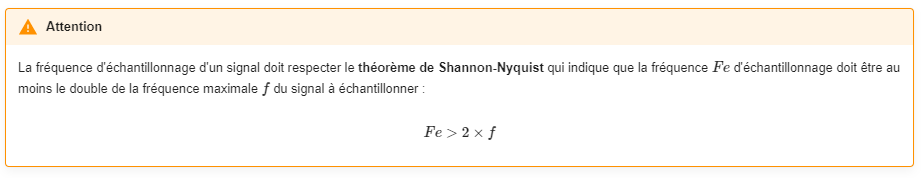

un taux d’échantillonnage donné peut enregistrer avec précision des fréquences audio jusqu’à un peu moins de la moitié de sa valeur cette limite de la moitié du taux d’échantillonnage s’appelle la fréquence de **Nyquist**

In [11]:
#creer colonne longueur
df["longueur"]=np.zeros(df.shape[0])
for i in tqdm(range(df.shape[0])):
    freq,signal=wavfile.read('/kaggle/input/freesound-audio-tagging/audio_train/'+df.loc[i,'fname'])
    df.loc[i,"longueur"]=signal.shape[0]/freq #longeur de signal en seconde

100%|██████████| 3000/3000 [00:33<00:00, 88.33it/s] 


In [12]:
df

,fname,label,longueur
0,00044347.wav,Hi-hat,14.00
1,001ca53d.wav,Saxophone,10.32
2,00353774.wav,Cello,4.52
3,003b91e8.wav,Cello,13.28
4,004ad66f.wav,Clarinet,7.00
...,...,...,...
2995,ff55a1e2.wav,Acoustic_guitar,14.66
2996,ff752a0c.wav,Clarinet,6.00
2997,ff875923.wav,Cello,11.84
2998,ffc92b01.wav,Cello,6.24


In [13]:
label_dist=df.groupby(['label'])['longueur'].mean()
label_dist

label
Acoustic_guitar     10.430200
Bass_drum            2.569667
Cello                7.453267
Clarinet             6.947467
Double_bass          3.373467
Flute                9.237400
Hi-hat               3.718067
Saxophone            6.745200
Snare_drum           3.587000
Violin_or_fiddle     5.325800
Name: longueur, dtype: float64

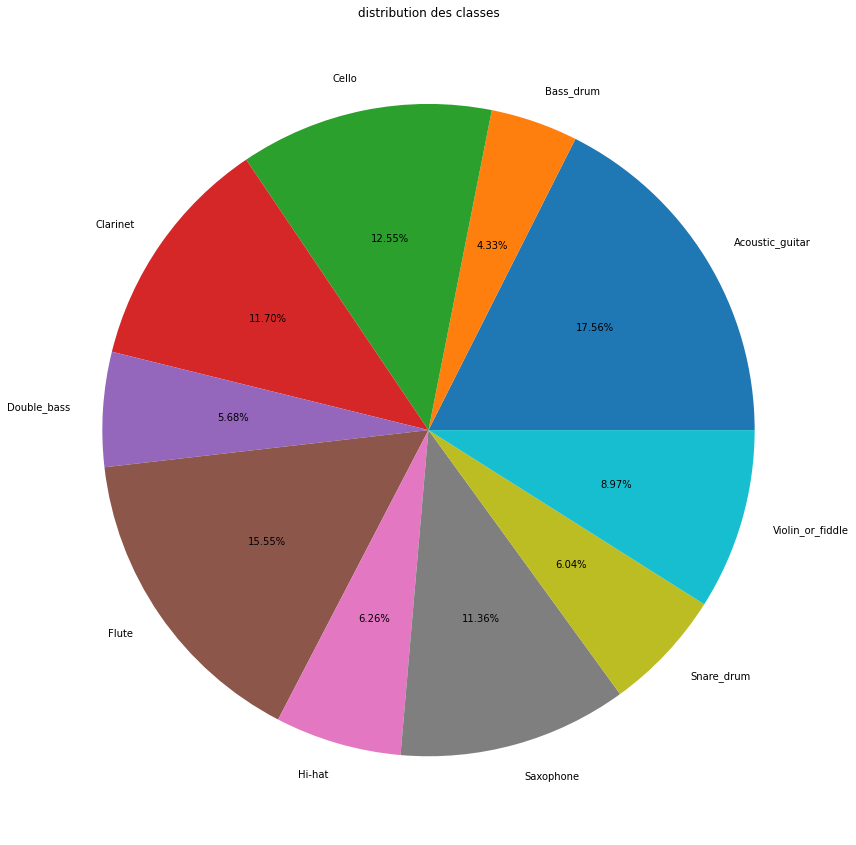

In [14]:
fig=plt.figure(figsize=(15,15))
plt.pie(label_dist,labels=label_dist.index,autopct='%2.2f%%')
plt.title("distribution des classes")
plt.show()

# 2) Extraction des caractéristiques audio


### Enveloppe d'un signal 

L'enveloppe sonore est la courbe décrivant l'évolution d'une propriété d'un son
ici on va calculer la moyenne pour une fenetre de un dixieme de seconde et prendre seulement les amplitude ou la moyenne depasse une seuil alpha.
avec cela on obtient des courbes plus lisse et plus pertinent (sans bruit) 

In [15]:
def signal_envelope (signal,rate,alpha):
    y=pd.Series(signal).apply(np.abs)#convertir to pandas serie
    y_moy=y.rolling(window=int(rate/10),min_periods=1,center=True).mean() #calculer la moyenne pour une fenetre d'un dixeme de seconde
    return(signal[y_moy>alpha])

### transformation de Fourier 

**definition** :
la transformation de fourier permet de representer le spectre des frequences d'un signal non periodiques.

**Rq**:
on normalise notre signal par sa longueur pour garantir un equilibre 
car:
la longueur de signal influe la frequence (nombre de fois qu'un amplitude donnée se repete) 

In [16]:
def fft(signal,freq):
    n=signal.shape[0]
    f_freq=np.fft.rfftfreq(n,d=1/freq) # Fréquences de la transformée de Fourier
    
    f=abs(np.fft.rfft(signal)/n) # Transformée de fourier
    return (f,f_freq)

### Filter bank coefficients &  Mel cepstrum coefficients 

Les coefficients de filtre de bande sont une technique utilisée pour extraire des caractéristiques d'un signal audio. Il s'agit d'une méthode de transformation du signal qui permet de séparer un signal audio complet en plusieurs bandes de fréquences. Chacune de ces bandes est ensuite analysée séparément pour extraire des caractéristiques spécifiques. Les coefficients de filtre de bande sont souvent utilisés pour la reconnaissance de la parole, la reconnaissance musicale et la classification audio, car ils permettent de capturer les caractéristiques spectrales d'un signal audio qui sont souvent importantes pour ces tâches.
Les filtres utilisés pour séparer les fréquences sont généralement des filtres de Mel ou de Bark, qui sont des filtres basés sur les caractéristiques de l'oreille humaine. Ces filtres permettent de créer des bandes de fréquences qui sont plus proches de la façon dont l'oreille humaine perçoit les sons.

entrée: signal audio (np.array)

retourne: un tableau ou chaque ligne contient un vecteur de caractéristiques

In [17]:
signals={}
fast_fourier_transform={}#fast Fourier transform (FFT)
filter_bank={} #Filter bank coefficients  
mel_cepstrum={} #Mel cepstrum coefficients

Tous les échantillons audio de cet ensemble de données proviennent de Freesound:https://zenodo.org/record/2552860#.XFD05fwo-V4
et ils sont fournis ici sous forme de fichiers audio mono PCM 16 bits, 44,1 kHz, non compressés.

In [18]:
rate=44100

**nfilt** :le nombre de filtres dans filter bank and mfcc

**nfft** :la taille de FFT pour une longueur de fenetre de 0.025 (par default) on a rate x 0.025 bins


In [19]:
for label in instruments: 
    fname=df[df["label"]==label].iloc[0,0] #premier exemple avec label="label"
    signal,freq=librosa.load('/kaggle/input/freesound-audio-tagging/audio_train/'+fname,sr=rate)
    signals[label]=signal
    fast_fourier_transform[label]=fft(signal,freq)
    filter_bank[label]=logfbank(signal=signal,samplerate=freq,
                                nfilt=26,nfft=rate//40+1).T
    mel_cepstrum[label]=mfcc(signal=signal[:freq],samplerate=freq,numcep=13,
                             nfilt=26,nfft=rate//40+1).T

In [20]:
def plot(Data,Type): 
    nrows=2
    ncols=5
    titles=list(Data.keys())
    values=list(Data.values())
    n=0
    fig,axes=plt.subplots(figsize=(20,5),nrows=nrows,ncols=ncols,sharex=False,sharey=True)
    #title 
    if (Type=='signal'):
        fig.suptitle('signal',size=18)
    elif (Type=="enveloppe"):
        fig.suptitle("enveloppe",size=18)
    elif (Type=="fft"):
        fig.suptitle('Transformation De Fourier',size=18)
    elif (Type=="fbank"):
        fig.suptitle("Filter Bank",size=18)
    else:
        fig.suptitle("Mel-frequency Cepstrum ",size=18)
        
    for i in range(nrows):
        for j in range(ncols):
            axes[i,j].set_title(titles[n])
            if (Type=="signal"):
                axes[i,j].plot(values[n],color='r')
            elif (Type=="enveloppe"):
                axes[i,j].plot(signal_envelope (values[n],rate=rate,alpha=0.0005))
            elif (Type=="fft"):
                f,freq=values[n]
                axes[i,j].plot(freq,f,'g')
            elif (Type=="fbank"):
                axes[i,j].imshow(values[n],cmap='hot',interpolation='nearest')
            else:
                axes[i,j].imshow(values[n],cmap='hot',interpolation='nearest')

            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            n+=1
    plt.show()

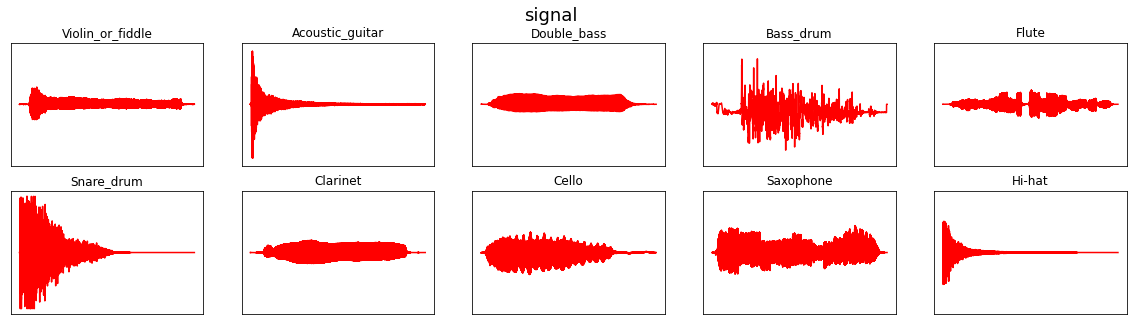

In [21]:
plot(signals,"signal")

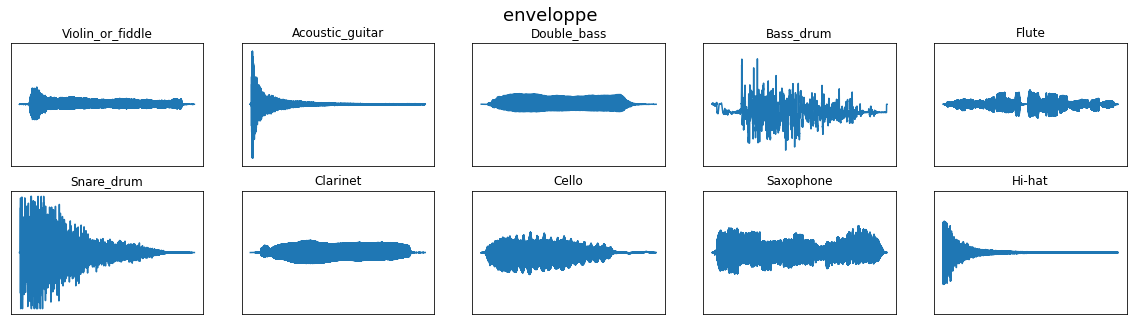

In [22]:
plot(signals,"enveloppe")


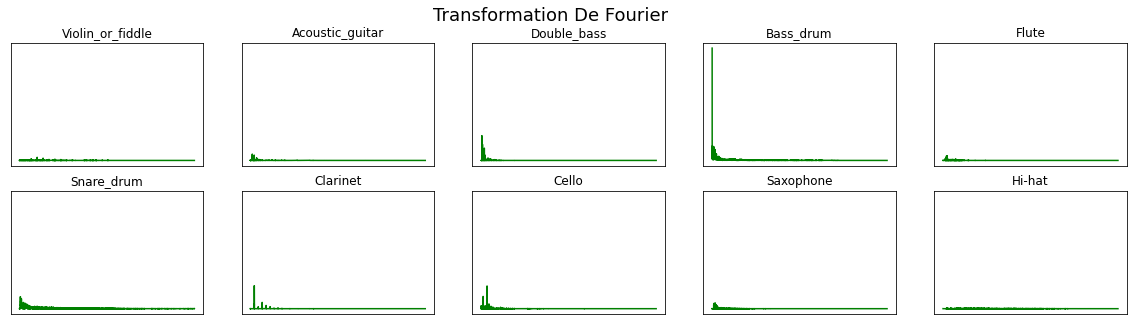

In [23]:
plot(fast_fourier_transform,'fft')


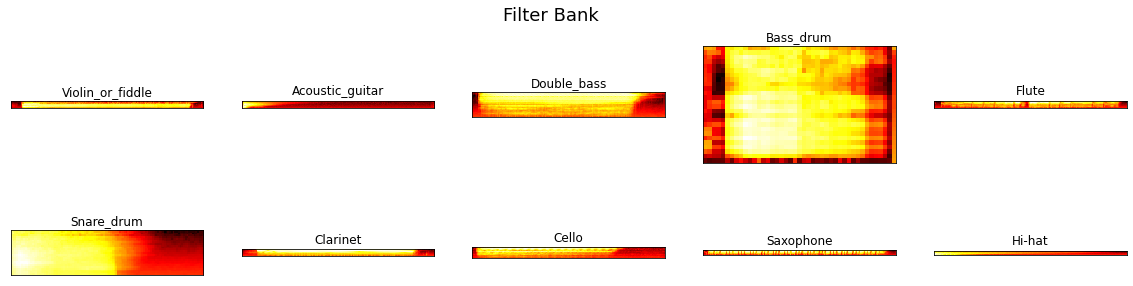

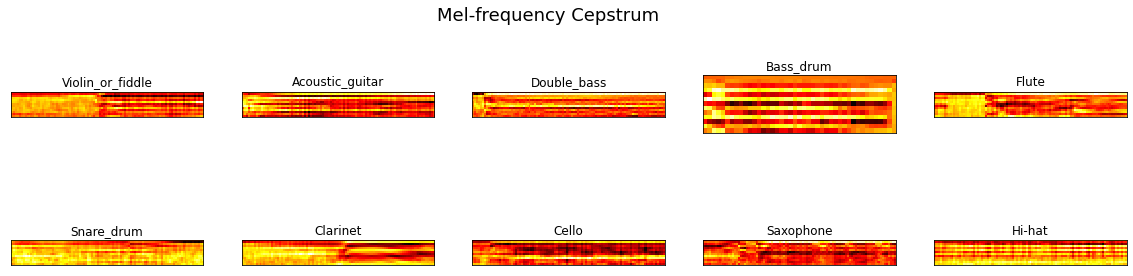

In [24]:
plot(filter_bank,'fbank')
plot(mel_cepstrum,'')

# 3) pretraitement des données 

on reduit la frequence d'echantillionnage a 16000 pour creer des données plus compactes via le sous echantillionnage 

In [25]:
#nettoyer et enregistrer tous les signals nettoyées 
def nettoyer(choix):
    rate=16000
    for i in tqdm(range(df.shape[0])):
        file=df['fname'][i]
        if choix==1:
            signal,_=librosa.load('/kaggle/input/freesound-audio-tagging/audio_train/'+file,sr=rate)
            clean=signal_envelope(signal,rate,0.0005)
            wavfile.write('/kaggle/working/'+file,rate=rate,data=clean)
        elif choix==2:
            rate,signal=wavfile.read('/kaggle/working/'+file)
        #mise a jour de longueur apres nettoyage 
        df.loc[i,"longueur"]=signal.shape[0]/rate
    return(df)

les données audio sont differentes des autres données car elles sont echantillionné frequemment c'est pour cela qu'on va proceder de la façon suivante :
1) on va fixer une taille de fenetre = 0.1 s

2) on va esseyer de reduire la taille de données pour l'entrainement tout en gardant la meme distibution de probabilités pour les differents instriments (meme proportion de taille de données pour chaque instrument):
    
    a) on va effectuer `nb_tirage=longueur_totale/0.1` tirages aleatoires suivant les probabilités initiales .
    
    b) on extrait une fenetre de taille 0.1 s de chaque tirage ce qui correspond a `rate/10` en données 

quantité finale de données = quantité de données initale 
mais avec des signals de longueur 0.1 s 

In [26]:
def creer_X_y(long_fenetre=int(rate/10)):
    X_y=pd.DataFrame(columns=['file','signal','label','label_id'])
    #initialiser mini et max a  -inf et +inf
    mini,maxi=float('inf'),-float('inf')
    for i in tqdm(range(taille_echantillion)):
        #tirage aleatoire d'un label=instrument suivant probabilité initale 
        label_ =np.random.choice(label_dist.index,p=prob_dist)
        #choisir un fichier aleatoirement (uniforme) parmis les fichier du label tiré
        file=np.random.choice(df[df['label']==label_]['fname']) 
        #lire le fichier tirée 
        rate_,signal_=wavfile.read('/kaggle/working/'+file)
        if signal_.shape[0]<long_fenetre:
            continue
        #choisir fenetre aleatoire dans le signal:        
        debut_fenetre=np.random.randint(0,signal_.shape[0]-long_fenetre)
        #extraire la fenetre
        fenetre=signal_[debut_fenetre:debut_fenetre+long_fenetre]
        wavfile.write('/kaggle/working/'+str(i)+".wav",rate=rate,data=fenetre)
        #calculer mfcc
        x=mfcc(fenetre,rate_).T
        
        mini=min(np.amin(x),mini)
        maxi=max(np.amax(x),maxi)
        X_y.loc[i,"file"]=str(i)+".wav"
        X_y.loc[i,"signal"]=x
        X_y.loc[i,"label"]=label_
        X_y.loc[i,"label_id"]=list(instruments).index(label_)
    return(X_y,mini,maxi)

In [27]:
#en lisant les données sauvegarder (output de mfcc ) qui sont initialement des np.array  on se trouve avec des chaine de caracteres '[['123','457'],['789','898']]' 
#cette fonction permet de transformer ces deriers en array
def transform(matrice):
    import re 
    X=[]
    matrice=matrice.replace('\n ','').replace("[[",'').replace(']]','').split('][')
    for i in range(len(matrice)):    
        L=re.sub(r'\s+', ' ', matrice[i])
        L=L.strip().split(' ')

        for k in range(len(L)):
            L[k]=float(L[k])
        X.append(L)
    return(np.array(X))

In [38]:
def echantillionnage(choix):
    if choix==1:
        Xy,mini,maxi=creer_X_y()
        #split X_y
        X=np.array(Xy.signal.values.tolist())
        y=np.array(Xy.label_id.values.tolist())

        #normaliser X
        X=(X-mini)/(maxi-mini)
        #save dataframe
        Xy['signal']=list(X)
        Xy.to_csv("/kaggle/working/echantillion.csv",index=False)
        pd.DataFrame({"mini":[2],"maxi":[3]}).to_csv('/kaggle/working/minmax.csv',index=False)
        #transformer Y a une variable categorique(hot_encoding)
    elif choix==2:
        Xy=pd.read_csv("/kaggle/working/echantillion.csv")
        Xy.signal=Xy.signal.map(lambda x:transform(x))
        #split X_y
        X=np.array(Xy.signal.values.tolist())
        y=np.array(Xy.label_id.values.tolist())
    y_one_hot=to_categorical(y,num_classes=10)
    return(Xy,X,y,y_one_hot)

La méthode de descente de gradient utilise des poids pour ajuster les paramètres d'un modèle en fonction des erreurs de prédiction. Les poids peuvent être ajustés en utilisant des techniques telles que le calcul des poids de classe pour traiter les déséquilibres de classe dans les données d'entraînement.

Les poids de classe sont utilisés pour donner plus d'importance aux classes qui ont moins d'exemples dans les données d'entraînement. 

En utilisant des poids de classe, vous pouvez éviter que le modèle ne surprenne les classes qui ont plus d'exemples et ne prédise correctement que ces classes, ce qui peut entraîner une performance inférieure pour les classes moins représentées.

Il existe plusieurs façons de calculer les poids de classe, mais l'une des méthodes les plus courantes est de les calculer en utilisant la fréquence inverse de la classe. Cela signifie que le poids d'une classe est inversément proportionnel à la fréquence de cette classe dans les données d'entraînement.

# 4) models

In [29]:
def conv(X):
    #sample n,features,Time Steps
    conv_input=X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    model=Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',
                    strides=(1,1),padding="same",input_shape=conv_input[0].shape))
    model.add(Conv2D(32,(3,3),activation='relu',
                     strides=(1,1),padding="same"))
    model.add(Conv2D(64,(3,3),activation='relu',
                     strides=(1,1),padding="same"))
    model.add(Conv2D(128,(3,3),activation='relu',
                     strides=(1,1),padding="same"))

    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())

    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))

    model.add(Dense(10,activation='softmax'))#classification, n_class=10 
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return (conv_input,model)

In [42]:
def lstm(X):
    #input shape: sample n,Time Steps,features
    X_lstm=[]
    for x in X:
        X_lstm.append(x.T)
    X_lstm=np.array(X_lstm)
    
    model=Sequential()
    #LSTRM input shape n,time=9,feat=13
    model.add(LSTM(128,return_sequences=True,input_shape=X_lstm[0].shape))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.5))

    model.add(TimeDistributed(Dense(64,activation='relu')))
    model.add(TimeDistributed(Dense(32,activation='relu')))
    model.add(TimeDistributed(Dense(16,activation='relu')))
    model.add(TimeDistributed(Dense(8,activation='relu')))

    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))

    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return(X_lstm,model)

In [31]:
def evaluation(model,history,X_test,y_test): 
    from sklearn.metrics import f1_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
    from sklearn.model_selection import learning_curve,cross_val_score


    y_pred_flat=np.argmax(model.predict(X_test),axis=-1)
    y_test_flat=np.argmax(y_test,axis=-1)

    disp = ConfusionMatrixDisplay.from_predictions(
                                              y_test_flat,
                                              y_pred_flat, 
                                              display_labels=instruments, 
                                              cmap=plt.cm.Reds
                                              )
    fig = disp.figure_
    fig.set_figwidth(7)
    fig.set_figheight(7)
    plt.xticks(rotation=90)
    fig.suptitle('matrice de confusion')
    plt.show()

    plt.figure(figsize=(10,7))
    plt.subplot(1, 2,1)
    plt.plot(history['loss'], 'b-', label='train loss')
    plt.plot(history['val_loss'], 'r-', label='val loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1,2, 2)
    plt.plot(history['acc'], 'b-', label='train accuracy')
    plt.plot(history['val_acc'], 'r-', label='val accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

In [43]:
def entrainer_model(choix,X,y,y_one_hot,epochs=20):
    poids_classe=compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
    poids_classe={i:poids_classe[i] for i in range(len(poids_classe)) }
    if choix==1:
        X_,model=conv(X)
    elif choix==2:
        X_,model=lstm(X)
    X_train, X_test, y_train, y_test = train_test_split(X_, y_one_hot, test_size=0.2, random_state=7)
    hist=model.fit(X_train,y_train,epochs=epochs,class_weight=poids_classe,validation_data=(X_test,y_test))
    history=pd.DataFrame(hist.history)
    if choix==1:
        #enregistrer history
        history.to_csv('/kaggle/working/history_conv.csv',index=False)
        # enregistrer the weights
        model.save_weights('/kaggle/working/checkpoint_conv')
    elif choix==2:
        #enregistrer history
        history.to_csv('/kaggle/working/history_lstm.csv',index=False)
        # enregistrer the weights
        model.save_weights('/kaggle/working/checkpoint_lstm')
    evaluation(model,history,X_test,y_test)
    return(model,history)

In [33]:
def load_model(choix,X):
    if choix==1:
        X_,model=conv(X)
        model.load_weights('/kaggle/working/checkpoint_conv')
        history=pd.read_csv('/kaggle/working/history_conv.csv')
    elif choix==2:
        X_,model=lstm(X)
        model.load_weights('/kaggle/working/checkpoint_lstm')
        history=pd.read_csv('/kaggle/working/history_lstm.csv')
    return(model,history)

avec cette fonction vous pouvez choisir de : 
* importer des données sauvegarder et pretraités ou effectuer un nouveau traitement ( nettoyage & echatillionnage )

* entrainer le model ou importer un model sauvegardé 

In [34]:


#si je multiplie la taille_echantillion par 2 ou 3 je vais avoir des meilleurs resultat(~ augmantation de 2% au niveau des mesures) mais cela va prendre 1h de 
#de plus pour l'echantillionnage 
longueur_totale=df["longueur"].sum()
taille_echantillion=int(longueur_totale.sum( )/0.1)
#probabilité de disctribution pour les differents instruments
label_dist=df.groupby(['label'])['longueur'].mean()
prob_dist=label_dist/label_dist.sum()

rate=16000
def main():    
    choix=int(input("*)pour nettoyer et sauvegarder deux nouveaux signiaux 1\n*)pour importer des signaux traités déja 2\n"))
    print('distribution des données:\n',prob_dist)
    
    #nettoyage
    if choix==1:print('\n** nettoyage **\n')
    df=nettoyer(choix)

    #echantillionnage
    if choix==1:print('\n** echantillionage **\n')
    Xy,X,y,y_one_hot=echantillionnage(choix)
    
    #modele:
    choix1=int(input("\n\n*)Pour entrainer un modele 1\n*)Pour importer un modele entrainé 2\n"))
    if choix1==1:
        choix2=int(input("choisir un modele\n1)Conv\n2)LSTM\n"))
        history,model=entrainer_model(choix2,X,y,y_one_hot)
        return(history)
    elif choix1==2:
        choix2=int(input("choisir un modele\n1)Conv\n2)LSTM\n"))
        history,model=load_model(choix2,X)
        


*)pour nettoyer et sauvegarder deux nouveaux signiaux 1
*)pour importer des signaux traités déja 2
 2


distribution des données:
 label
Acoustic_guitar     0.175629
Bass_drum           0.043269
Cello               0.125502
Clarinet            0.116985
Double_bass         0.056804
Flute               0.155544
Hi-hat              0.062607
Saxophone           0.113579
Snare_drum          0.060400
Violin_or_fiddle    0.089679
Name: longueur, dtype: float64


100%|██████████| 3000/3000 [00:01<00:00, 2196.28it/s]




*)Pour entrainer un modele 1
*)Pour importer un modele entrainé 2
 1
choisir un modele
1)Conv
2)LSTM
 1


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 13, 27, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 27, 32)        4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 27, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 27, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 13, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 13, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9984)             

2023-01-16 06:59:53.883063: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 197605980 exceeds 10% of free system memory.


Epoch 1/20
4399/4399 [==============================] - 27s 6ms/step - loss: 0.9952 - acc: 0.6159 - val_loss: 0.7526 - val_acc: 0.7310
Epoch 2/20
4399/4399 [==============================] - 26s 6ms/step - loss: 0.6324 - acc: 0.7574 - val_loss: 0.5879 - val_acc: 0.8004
Epoch 3/20
4399/4399 [==============================] - 25s 6ms/step - loss: 0.5125 - acc: 0.8026 - val_loss: 0.4581 - val_acc: 0.8469
Epoch 4/20
4399/4399 [==============================] - 26s 6ms/step - loss: 0.4381 - acc: 0.8303 - val_loss: 0.4144 - val_acc: 0.8588
Epoch 5/20
4399/4399 [==============================] - 26s 6ms/step - loss: 0.3924 - acc: 0.8483 - val_loss: 0.4047 - val_acc: 0.8607
Epoch 6/20
4399/4399 [==============================] - 26s 6ms/step - loss: 0.3631 - acc: 0.8602 - val_loss: 0.3677 - val_acc: 0.8732
Epoch 7/20
4399/4399 [==============================] - 26s 6ms/step - loss: 0.3364 - acc: 0.8693 - val_loss: 0.3368 - val_acc: 0.8854
Epoch 8/20
4399/4399 [==============================] -

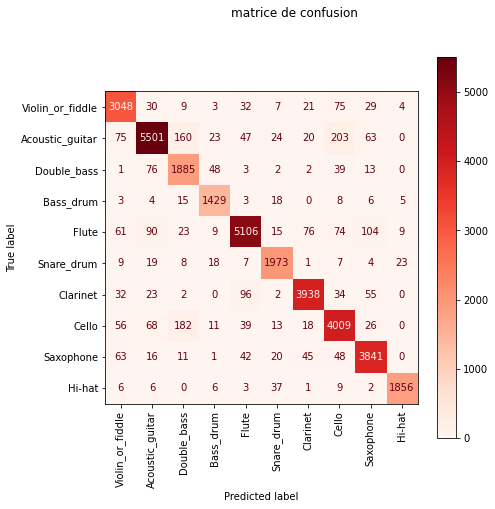

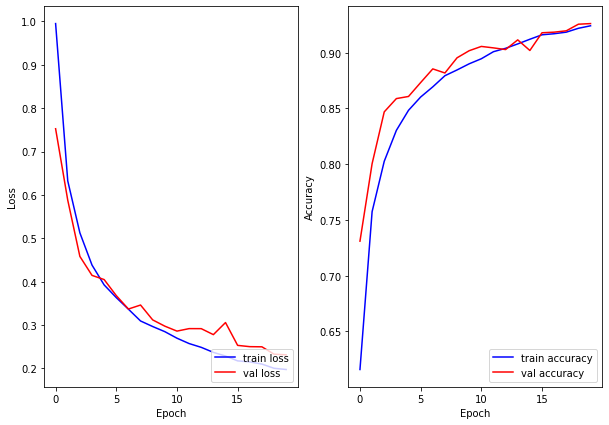

In [39]:
main()

*)pour nettoyer et sauvegarder deux nouveaux signiaux 1
*)pour importer des signaux traités déja 2
 2


distribution des données:
 label
Acoustic_guitar     0.175629
Bass_drum           0.043269
Cello               0.125502
Clarinet            0.116985
Double_bass         0.056804
Flute               0.155544
Hi-hat              0.062607
Saxophone           0.113579
Snare_drum          0.060400
Violin_or_fiddle    0.089679
Name: longueur, dtype: float64


100%|██████████| 3000/3000 [00:01<00:00, 2128.14it/s]




*)Pour entrainer un modele 1
*)Pour importer un modele entrainé 2
 1
choisir un modele
1)Conv
2)LSTM
 2


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 27, 128)           72704     
_________________________________________________________________
lstm_3 (LSTM)                (None, 27, 128)           131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 27, 128)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 27, 64)            8256      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 27, 32)            2080      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 27, 16)            528       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 27, 8)            

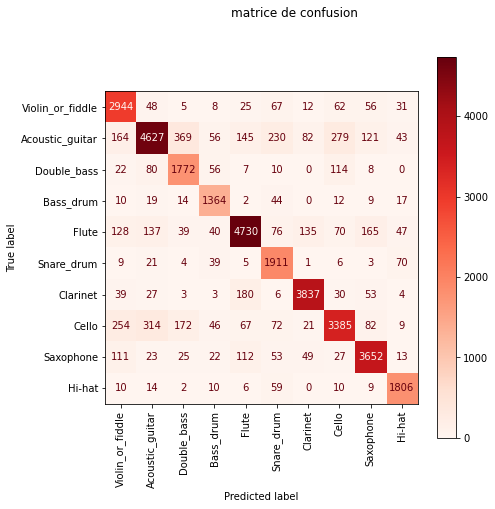

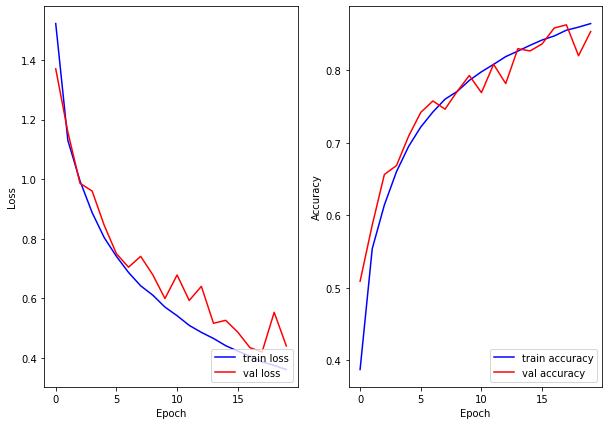

In [44]:
main()

# 5) comparaison 

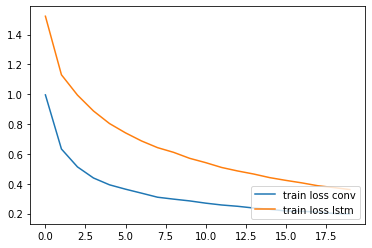

In [45]:
hist_conv=pd.read_csv('/kaggle/working/history_conv.csv')
hist_lstm=pd.read_csv('/kaggle/working/history_lstm.csv')
plt.plot(hist_conv['loss'],label='train loss conv')
plt.plot(hist_lstm['loss'],label='train loss lstm')
plt.legend(loc='lower right')

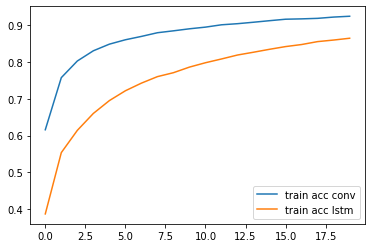

In [46]:
hist_conv=pd.read_csv('/kaggle/working/history_conv.csv')
hist_lstm=pd.read_csv('/kaggle/working/history_lstm.csv')
plt.plot(hist_conv['acc'],label='train acc conv')
plt.plot(hist_lstm['acc'],label='train acc lstm')
plt.legend(loc='lower right')

CNN était a 61% après la première époque qui a durée 24s et 92.4% a la derniere epoque
 
LSTM était a 38%% aprés la premiere époque qui a durée 39s et 
 
•Meilleurs résultats avec CNN cela peut s’expliquer par la différence de nombre de paramètres lstm=216018 > CNN= 449402

•CNN est aussi plus rapide que LSTM. 


# faire des predictions

In [65]:
Xy,X,y,y_one_hot=echantillionnage(2)#importer data
model,history= load_model(1,X)#on choisit CNN
#recuperer le mini et maxi(enregistrés lors de la creation de X_y) pour transformation du fichiers
minmax=pd.read_csv('/kaggle/working/minmax.csv')
mini=minmax["mini"].values[0]
maxi=minmax["maxi"].values[0]

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 13, 27, 16)        160       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 13, 27, 32)        4640      
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 13, 27, 64)        18496     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 13, 27, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 13, 128)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 6, 13, 128)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 9984)            

In [163]:
#choisir un fichier aleatoirement
i=np.random.choice(df.shape[0]) 
file=df['fname'][i]
label=df['label'][i]
#lire le fichier tirée 
rate,signal=wavfile.read('/kaggle/working/'+file)
#decouper en fenetre de 1/10s
y_preds=[]
for i in range(0,len(signal)-int(44100/10),int(44100/10)):
    fenetre=signal[i:i+int(44100/10)]
    x=mfcc(fenetre,rate)
    x=x.reshape(1,x.shape[0],x.shape[1],1)
    y_preds.append(np.argmax(model.predict(x)))


In [180]:
from IPython.display import Audio
Audio(np.array(signal),rate=16000)

In [183]:

fenetres_predictions=pd.Series(y_preds).map(lambda i:instruments[i])
print(f'apres decomposition de {file} en fenetres on obtient les predictions:\n {fenetres_predictions}')
print(f'vrai label de {file} est {label} qui est le label majoritaire des fenetres :D ')

apres decomposition de bce8e045.wav en fenetres on obtient les predictions:
 0     Acoustic_guitar
1     Acoustic_guitar
2     Acoustic_guitar
3     Acoustic_guitar
4     Acoustic_guitar
5     Acoustic_guitar
6            Clarinet
7            Clarinet
8     Acoustic_guitar
9            Clarinet
10    Acoustic_guitar
11    Acoustic_guitar
12              Flute
13    Acoustic_guitar
14    Acoustic_guitar
dtype: object
vrai label de bce8e045.wav est Acoustic_guitar qui est le label majoritaire des fenetres :D 


# Apprentissage par transfert avec YAMNet

YAMNet est un réseau neuronal préformé qui utilise l'architecture de convolution séparable en profondeur MobileNetV1 . Il peut utiliser une forme d'onde audio comme entrée et faire des prédictions indépendantes pour chacun des 521 événements audio du corpus AudioSet .

**entrée : ** une tenseur 1D float32 ou numpy.array de longueur quelconque normalisé entre -1 et 1

**sorties :** les score des classes,pre-frame enbeddings (sorie moyenne qui alimente la couche finale de classification),log_mel_spectrogram 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_modelf = hub.load(yamnet_model_handle)

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

In [ ]:
#les differents classe avec les quels yamnet est entrainé 
print(class_names)

In [ ]:
#encode label 
df=pd.read_csv("/kaggle/working/echantillion.csv")
df=df[["file","label_id"]].copy()

In [ ]:
df.head()

In [ ]:
#normalisation de signal entre -1 et 1 comme l'input du modele 
def lire_normaliser(filename):
    signal,rate=librosa.load('/kaggle/working/'+filename,sr=16000)
    signal=tf.expand_dims(signal,axis=1)
    signal=tf.audio.encode_wav(signal,sample_rate=16000,name=None)
    signal,sample_rate=tf.audio.decode_wav(signal,desired_channels=1)
    signal = tf.squeeze(signal, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    signal = tfio.audio.resample(signal, rate_in=sample_rate, rate_out=16000)
    return signal

In [ ]:
#importer les fenetres de signals(echantillion) sauvegardés deja et normalisation entre -1,1 (condition pour finetuning yamnet)
signal=[]
for i in tqdm(range(len(df))):
    signal.append(lire_normaliser(df.loc[i,'file']))

In [ ]:
for i in tqdm(range(len(df))):
    df.signal[i]=np.array(signal[i]).reshape(-1)

In [ ]:
df.head()

In [ ]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data):
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    return (embeddings)

In [ ]:
for i in tqdm(range(len(df))):
    df.signal[i]=np.array(extract_embedding(df["signal"][i])).reshape(-1)

In [ ]:
X=df["signal"].values
y=df['label'].values
y_one_hot=to_categorical(y,num_classes=10)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=7)

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,1024),
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(instruments))
], name='my_model')
my_model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])

In [ ]:
history=model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test))